# 14 · Inter‑ vs Within‑Subject RSA

Compare parcel‑wise reliability *within* subjects (WS) to *between* subjects (IS, shift=1) and visualise WS on the cortical surface. We also quantify the functional relation between both metrics via a zero‑intercept power law.


## 1. Imports

Load plotting/stat utilities and our project helpers for colorbars and cortical maps.

In [1]:
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from convergence.figures import plot_cbar_set, setup_matplotlib_fonts
from convergence.plotting import plot_faverage_parcelation
from convergence.power_law import fit_powerlaw_zero_with_bootstrap

setup_matplotlib_fonts()

## 2. Data paths

Point to:  
- HCP atlas metadata (`hcp.csv`)  
- Shifted subject–subject RSA (joined & separated hemispheres)  
- Output folder for figures


In [2]:
derivatives_folder = Path("../derivatives")
hcp_filename = derivatives_folder / "metadata" / "hcp.csv"

# RSA alignment. Subject Shifted
filename_rsa = derivatives_folder / "nsd" / "rsa_subject_subject_alignment_shift_1_joined.parquet"
filename_rsa_separated = derivatives_folder / "nsd" / "rsa_subject_subject_alignment_shift_1_separated.parquet"

figures_folder = Path("../figures")
output_folder = figures_folder / "14_inter_vs_within_rsa"
output_folder.mkdir(exist_ok=True, parents=True)

## 3. Aggregate WS and IS RSA

From the joined table, keep diagonal ROI pairs and average across subject pairs:

- **WS**: `subject_i == subject_j`  
- **IS**: `subject_i != subject_j`

Merge both into a single DataFrame and attach HCP area labels for plotting.


In [3]:
df = pd.read_parquet(filename_rsa)
df = df.query("subject_i == subject_j and roi_x == roi_y").groupby(["roi_x"]).similarity.mean().reset_index()
df = df.rename(columns={"similarity": "self_similarity", "roi_x": "roi"})
df_cross = pd.read_parquet(filename_rsa)
df_cross = df_cross.query("subject_i != subject_j and roi_x == roi_y").groupby(["roi_x"]).similarity.mean().reset_index()
df_cross = df_cross.rename(columns={"similarity": "cross_similarity", "roi_x": "roi"})
df = df.merge(df_cross, on="roi")
hcp = pd.read_csv(hcp_filename)
hcp = hcp[["roi", "name", "mne_name", "area", "area_color", "area_id"]]
df = df.merge(hcp, on="roi")
df

,roi,self_similarity,cross_similarity,name,mne_name,area,area_color,area_id
0,1,0.224112,0.194511,V1,L_V1_ROI-lh,Primary Visual,#1f77b4,0
1,2,0.284116,0.210775,MST,L_MST_ROI-lh,MT+ Visual Areas,#2ca02c,6
2,3,0.030256,0.012278,V6,L_V6_ROI-lh,Dorsal Visual,#ff9896,5
3,4,0.209218,0.177940,V2,L_V2_ROI-lh,Early Visual (V2-4),#aec7e8,1
4,5,0.164987,0.125448,V3,L_V3_ROI-lh,Early Visual (V2-4),#aec7e8,1
...,...,...,...,...,...,...,...,...
175,176,0.011450,0.004292,STSva,L_STSva_ROI-lh,Auditory Association,#f7b6d2,13
176,177,0.004854,0.001881,TE1m,L_TE1m_ROI-lh,Lateral Temporal,#d62728,4
177,178,0.000014,0.000320,PI,L_PI_ROI-lh,Insula & Frontal Operculum,#7f7f7f,14
178,179,0.005158,0.001305,a32pr,L_a32pr_ROI-lh,Anterior Cingulate & mPFC,#17becf,18


## 4. WS vs IS scatter + power‑law fit

We fit  
$$
\text{WS} = \alpha\,(\text{IS})^\beta
$$  
using a bootstrapped zero‑intercept power law (small ε shift to avoid log(0)).  
The curve (red) and 95 % CI (shaded) explain almost all variance (pseudo‑\(R^2\) ≈ reported in legend).  
Top 30 ROIs (by WS) are annotated to highlight hubs.

**Interpretation.** Parcels that align strongly across people also show high within‑subject reliability; the sublinear exponent (\(\beta<1\)) indicates disproportionate attenuation for low‑IS parcels.


Pseudo-R²: 0.981 N Boostrap samples: 10000


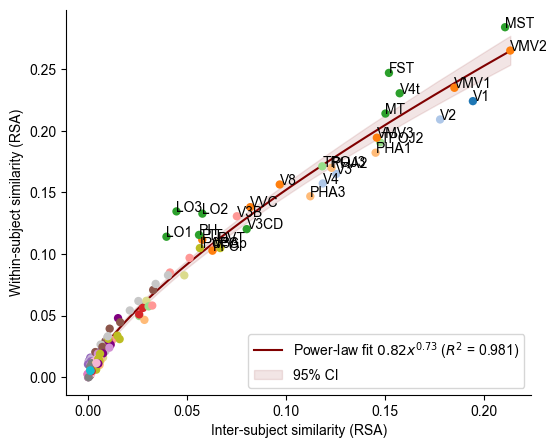

In [4]:

fig, ax = plt.subplots(figsize=(6, 5))
n_boot = 10000

palette = df[["area", "area_color"]].drop_duplicates().set_index("area").area_color.to_dict()

# Small shift to avoid log(0) issues
eps = 1e-6  
a = df.cross_similarity.min() - eps
b = df.self_similarity.min() - eps

x_fit, y_fit, y_lower, y_upper, r2, params =  fit_powerlaw_zero_with_bootstrap(
    df.cross_similarity - a, df.self_similarity - b, n_boot=1000, p0=[1, 0.5], n_points=200);

label = f"Power-law fit ${params[0]:.2f}x^{{{params[1]:.2f}}}$ ($R^2$ = {r2:.3f})"
ax.plot(x_fit + a, y_fit + b, color='maroon', label=label, zorder=-10)
ax.fill_between(x_fit + a, y_lower + b, y_upper + b, color='maroon', alpha=0.1, label='95% CI', zorder=-20)
print(f"Pseudo-R²: {r2:.3f} N Boostrap samples: {n_boot}")
ax.legend(loc="lower right", fontsize=10)
sns.scatterplot(data=df, y="self_similarity", x="cross_similarity", hue="area", legend=False, palette=palette, lw=0)

top_30 = df.nlargest(30, "self_similarity")
for i, row in top_30.iterrows():
    ax.text(row["cross_similarity"], row["self_similarity"], row["name"])

ax.set_ylabel("Within-subject similarity (RSA)")
ax.set_xlabel("Inter-subject similarity (RSA)")
sns.despine(ax=ax)

# Save as svg to edit manually the text positions
fig.savefig(output_folder / "01_inter_vs_within_rsa.svg", bbox_inches="tight", transparent=True)

## 5. Correlation checks

Report Pearson and Spearman correlations between WS and IS to document monotonicity and linearity.


In [5]:

corr = df.self_similarity.corr(df.cross_similarity)
print(f"Correlation between within and inter similarity: {corr:.2f}")
# Get correlation between self and cross similarity (spearman)
corr_spearman = df.self_similarity.corr(df.cross_similarity, method="spearman")
print(f"Spearman correlation between within and inter similarity: {corr_spearman:.2f}")


Correlation between within and inter similarity: 0.98
Spearman correlation between within and inter similarity: 0.95


## 6. WS cortical maps

Using the separated‑hemisphere table:

- Average WS per ROI  
- Project to fsaverage (LH & RH)  
- Save lateral / ventral / medial / caudal views (range ±0.25; RdBu_r)

These maps localise the strongest within‑subject reliability to EVC, VMV/PHA, and LOTC parcels.


In [6]:
df_separated = pd.read_parquet(filename_rsa_separated) # Change to filename_rsa to join hemisphere
df_separated = df_separated.query("subject_i == subject_j and roi_x == roi_y")
df_separated = df_separated.groupby(["roi_x"]).similarity.mean().reset_index()
df_separated = df_separated.rename(columns={"similarity": "self_similarity", "roi_x": "roi"})
hcp = pd.read_csv(hcp_filename)
hcp = hcp[["roi", "name", "mne_name"]]
df_separated = df_separated.merge(hcp, on="roi")
df_separated.self_similarity.max() # 0.26


hemispheres = ["lh", "rh"]
views = ["lateral", "ventral", "medial", "caudal"]
vmax = 0.25

for hemisphere in hemispheres:
    
    brain = plot_faverage_parcelation(df_separated,
                                    value_column="self_similarity",
                                    normalize=(-vmax, vmax),
                                    cmap="RdBu_r",
                                    default_color="lightgrey",
                                    default_value=None,
                                    hemisphere=hemisphere,
                                    )
    for view in views:
        brain.show_view(view)
        filename = output_folder / f"02_within_subject_similarity_{hemisphere}_{view}_{vmax:.2f}.png"
        brain.save_image(filename, mode="rgba")
        
    # brain.show() # For interactive viewing
    brain.close()

## 7. Quick PNG inspection

Display one saved PNG in‑notebook to verify rendering (optional for static export).


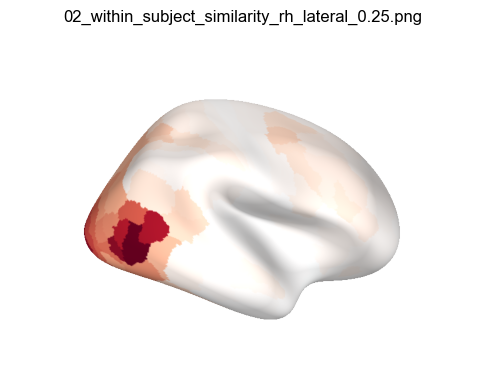

In [7]:
view = "lateral" # "lateral", "ventral", "medial", "caudal"
hemisphere = "rh" # "lh", "rh"
filename = output_folder / f"02_within_subject_similarity_{hemisphere}_{view}_{vmax:.2f}.png"
fig, ax = plt.subplots(figsize=(6, 5))
img = plt.imread(filename)
ax.imshow(img)
ax.axis("off")
ax.set_title(filename.name);

## 8. Standalone colorbar

Export a consistent colorbar for WS RSA (0 → 0.25) to re‑use in the manuscript.


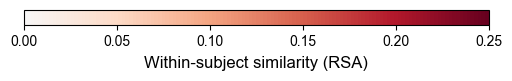

In [8]:
title = "Within-subject similarity (RSA)"
filename = output_folder / "02_within_subject_similarity_cbar.pdf"
plot_cbar_set(title=title, filename=filename, vmax=vmax, vmin=0, locator=0.05)


- WS and IS RSA follow a tight power‑law relationship, confirming they probe the same underlying geometry with different noise levels.  
- High‑reliability hubs (EVC, VMV/PHA, LOTC) replicate the inter‑subject pattern, reinforcing that cross‑subject alignment is not driven by a few idiosyncratic subjects.  
- The WS surface provides a convenient “upper bound” reference for interpreting IS and model–brain scores elsewhere in the paper.
- Although this power-law relation explain the most variance, individual rois variation can be substantial, suggesting that the relationship is not perfect and that there are other factors at play in determining within-subject reliability.